In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

# Standard second-order partial differential equation in two variables

## Advection-Diffusion-Reaction PDEs

For a bounded domain $\Omega \subset \mathbb{R}^2$ with boundary $\partial \Omega = \Gamma_D \cup \Gamma_N$, consider the boundary value problem

$$
\left\{
\begin{array}{ll}
- \nabla \cdot(k \nabla u) + \boldsymbol{w} \cdot \nabla u + c u = f  & \text{ in }  \Omega, \\
u = u_D & \text{ on }  \Gamma_D, \\
k \nabla u \cdot \boldsymbol{n} = g & \text{ on }  \Gamma_N.
\end{array}
\right.$$

Here, $\Gamma_D \subset \partial \Omega$ denotes the part of the boundary where we prescribe Dirichlet boundary conditions, and $\Gamma_N \subset \partial \Omega$ denotes the part of the boundary where we prescribe Neumann boundary conditions. $\boldsymbol{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$.

### The weak formulation of the above boundary value problem.

To derive the weak form, we first define the function spaces $V_{u_D}$ and $V_0$ subspaces of $H^1(\Omega)$ associated with the inhomogeneuos and homogeneuos form of the Dirichlet boundary condition:

$$ V_{u_D} = \{ v \in H^1(\Omega) \, | \, v = u_D \text{ on } \Gamma_D \}, \text{ and }
V_{0} = \{ v \in H^1(\Omega) \, | \, v = 0 \text{ on } \Gamma_D \}.$$

Then we multiply the strong form by an arbitrary function $v \in V_0$ and integrate over $\Omega$:

$$  \int_\Omega  \left(- \nabla \cdot(k \nabla u) + \boldsymbol{w} \cdot \nabla u + c u \right)\, v\, dx = \int_\Omega f\,v \, dx, \quad \forall v \in V_0. $$

Integration by parts of the second order term gives

$$ - \int_\Omega \nabla \cdot(k \nabla u)\, v \,dx = \int_\Omega k \, \nabla u \cdot \nabla v \, dx - \int_{\partial\Omega} (k \nabla u \cdot \boldsymbol{n}) \,v\, ds. $$

We obtain that:

$$ \int_\Omega k \nabla u \cdot \nabla v \, dx -  \int_{\partial\Omega} (k \nabla u \cdot \boldsymbol{n}) \,v\, ds + \int_\Omega \boldsymbol{w}\cdot \nabla u \, v\,dx + \int_\Omega c\, u\, v\, dx = \int_\Omega f\,v \, dx. $$

Recalling that $v = 0$ on $\Gamma_D$ and that $k \nabla u \cdot \boldsymbol{n} = g$ on $\Gamma_N$, the weak form of the BVP is the following.

Find $u \in V_{u_D}$:
$$ \int_\Omega k \nabla u \cdot \nabla v \, dx + \int_\Omega \boldsymbol{w}\cdot \nabla u \, v\,dx + \int_\Omega c\, u\, v\, dx = \int_\Omega f\,v \, dx + \int_{\Gamma_N} g\,v\,ds, \quad \forall v \in V_0. $$


### Application:

> Compute the finite element solution of the above problem on $\Omega = [0, 1]\times[0, 1] $ using FEniCS with $k = k(\boldsymbol{x}) = e^{-\|\boldsymbol{x}\|^2}$, $\boldsymbol{w} = [0,1]^t$, $c=1$, $f = 1$, $u_D = 0$, $g=0$. $\Gamma_N$ is the upper boundary of the unit square and $\Gamma_D$ is the remaining sides.

In [ ]:
# Import FEniCS
from fenics import *
import math

# Enable plotting inside the notebook
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline

Number of dofs 625


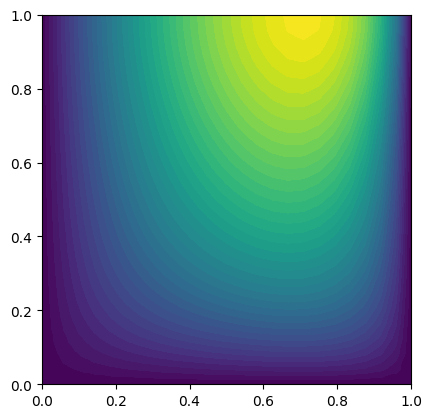

In [ ]:
n = 24
d = 1

mesh = UnitSquareMesh(n, n)

Vh = FunctionSpace(mesh, "Lagrange", d)
print("Number of dofs", Vh.dim())

def boundary_d(x, on_boundary):
    return (x[1] < DOLFIN_EPS or x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS) and on_boundary

u_d  = Constant(0.)
bcs = [DirichletBC(Vh, u_d, boundary_d)]

uh = TrialFunction(Vh)
vh = TestFunction(Vh)

k = Expression("exp(-x[0]*x[0] -x[1]*x[1])", degree = d+2)
w = Constant( (1.,0.))
c = Constant(1.)

f = Constant(1.)
g = Constant(0.)
a = k*inner(grad(uh), grad(vh))*dx + dot(w, grad(uh))*vh*dx + c*uh*vh*dx
L =  f*vh*dx + g*vh*ds

A, b = assemble_system(a, L, bcs) # to get A as Matrix
uh = Function(Vh)
solve(A, uh.vector(), b) # be careful

plot(uh, mytitle="Finite Element Solution")
plt.show()


#  Exercise 1

Modify the previous code to solve the following the boundary value problem:

\begin{eqnarray*}
-  \text{ div }(\mathbf k \mathbf{\nabla} u)  = f, &      \text{ in } &\Omega,   \tag{1}\\
u = u_0, & \text{ on } & \Gamma_D = \Gamma_{left} \cup \Gamma_{right}, \tag{2}\\
\frac{\partial u}{\partial {n}} = g, & \text{ on } &\Gamma_N = \Gamma_{top} \cup \Gamma_{bottom} , \tag{3}
\end{eqnarray*}

with
$$
\Omega = (0,1)^2,
$$

\begin{eqnarray*}
{\mathbf k}(x,y) = \bigg( \begin{array}{l} 2 & 1 \\ 1  & 2\end{array} \bigg ),
\end{eqnarray*}

$$ f(x, y) = 10 e^{-((x - 0.5)^2 + (y - 0.5)^2) / 0.02} $$
$$
u_\mathrm{0}(x, y) = 0,
$$
\begin{eqnarray*}
g(x, y) = sin(5x).
\end{eqnarray*}

The following script can be used to implement the thermal conductivity:
```
#
# Define thermal conductivity
#
k = as_matrix([[2.0 , 1.0] , [1.0 , 2.0]])
#
# Define variational problem
#
v = TestFunction(V)
u = TrialFunction(V)
a = inner(k*grad(u), grad(v))*dx
```

### Solution

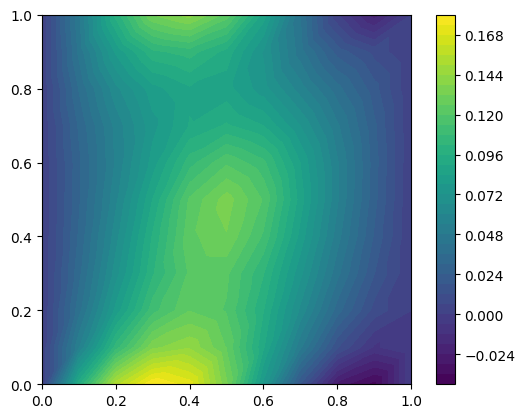

In [ ]:
from fenics import *
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline

# Create mesh and define function space
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, "CG", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x, on_boundary):
    return (on_boundary and x[0] < DOLFIN_EPS) or (on_boundary and x[0] > 1.0 - DOLFIN_EPS)

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Define the Top part of the boundary
class T_Boundary(SubDomain):
    def inside(self, x, on_boundary):
        return (on_boundary and abs(x[1] - 1) < DOLFIN_EPS)

# Define the Top part of the boundary
class B_Boundary(SubDomain):
    def inside(self, x, on_boundary):
        return  (on_boundary and abs(x[1]) < DOLFIN_EPS)

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

# mark the entire boundary as 0
boundary_parts.set_all(0)

# Mark the boundaries as subdomains  1, 2, 3 and 4

Gamma_top = T_Boundary()
Gamma_top.mark(boundary_parts, 1)

Gamma_Bot = B_Boundary()
Gamma_Bot.mark(boundary_parts, 2)
# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

# Define variational problem
A = as_matrix([[2.0 , 1.0] , [1.0 , 2.0]])
v = TestFunction(V)
u = TrialFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=3)
g = Expression("sin(5*x[0])", degree=3)
a = inner(A*grad(u), grad(v))*dx
L = f*v*dx + g*v*ds(1)+ g*v*ds(2)

U = Function(V)

# Assemble the left- and right-hand sides of the variational formulation:
# assembling the coefficient matrix A and the right-hand side vector b of
# the linear system

A = assemble(a)
b = assemble(L)
x = U.vector()

# Apply boundary conditions
bc.apply(A, b)

# Specify the solver method
solver = KrylovSolver()

# Solve linear system
solver.solve(A, x, b)


# Plot solution
p=plot(U, interactive=True)
plt.colorbar(p)
plt.show()